DFM / online-coupled bloom tracer Run
--

This version matches with run_dfm_bloom_tracers_v02 / bloom_tracers_v03.

Copied from plot_dfm_bloom_tracers_v03, this notebook drops the temperature calibration
code, focuses on growth potential.

In [31]:
import matplotlib.pyplot as plt
%matplotlib widget

In [32]:
import sys
sys.path.append("/richmondvol1/rusty/stompy")
from stompy import utils, xr_utils, memoize
import stompy.model.delft.dflow_model as dfm
import stompy.model.delft.waq_scenario as dwaq
from stompy.plot import plot_utils, plot_wkb
from stompy.grid import unstructured_grid
import stompy.plot.cmap as scmap
from stompy.spatial import proj_utils, field
from stompy.io.local import noaa_coops
from matplotlib import gridspec
import pdb

import os, time
import numpy as np
import xarray as xr
import pandas as pd

from IPython.display import Video
import time
import six
import datetime

In [34]:
# These online-coupled dfm-dwaq runs.

# Main run
#run_dir="bloom_tracers_v03/run_20220802T1200_20220830T0000_v00"
# Updated forcing for ocean BC, air temp, fix longitude for solar rad.
# run_dir="bloom_tracers_v04/run_20220802T1200_20220830T0000_v02"
# swim_speeds=[10]
# Switch to just 5 m/d, update temperature parameters:
# Use CdWind for Stanton and Dalton numbers
# run_dir="bloom_tracers_v05/run_20220802T1200_20220830T0000_v00"
# swim_speeds=[5]

# Get everything packaged up cleanly on ds/multiugrid
results=[]

In [35]:
if 0:
    run_dir="bloom_tracers_v06/run_20220802T1200_20220830T0000_v00"
    swim_speeds=[5,10]
    model=dfm.DFlowModel.load(run_dir)
    ds=model.map_dataset()
    ds['swim_speed']=('swim_speed',),[5.0,10.0]
    ds['run_dir']=(),run_dir
    ds['label'] = (),"v06 No temperature"
    results.append(ds)

In [36]:
if 1:
    run_dir="bloom_tracers_v07/run_20220802T1200_20220830T0000_v00"
    swim_speeds=[5,10]
    model=dfm.DFlowModel.load(run_dir)
    ds=model.map_dataset()
    ds['swim_speed']=('swim_speed',),[5.0,10.0]
    ds['run_dir']=(),run_dir
    ds['label'] = (),"v07 Temperature"
    results.append(ds)

In [37]:
if 1:
    run_dir="bloom_tracers_v08/run_20220802T1930_20220830T0000_v00"
    swim_speeds=[5,10]
    model=dfm.DFlowModel.load(run_dir)
    ds=model.map_dataset()
    ds['swim_speed']=('swim_speed',),[5.0,10.0]
    ds['run_dir']=(),run_dir
    ds['label'] = (),"v08 Temp, ACSPO IC"
    results.append(ds)

In [38]:
grid=results[0].grid
grid_poly=grid.boundary_polygon()

INFO:join_features:0 open strings, 16 simple polygons
INFO:join_features:Building index
/richmondvol1/rusty/stompy/stompy/spatial/join_features.py:514: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  p.join_id=i
INFO:join_features:done building index
INFO:join_features:Examining largest poly left with area=3212664407.249223, 15 potential interiors


Temperature 
--

In [8]:
# Representative points
# manual picks from plot
l2m=proj_utils.mapper('WGS84','EPSG:26910')
sites=dict( Alcatraz = np.r_[550030,4.18629e6],
            Alameda = np.r_[562410, 4.17998e6],
            SMB = np.r_[566900, 4.16085e6], 
            Pier17 = np.r_[553056, 4184134],
            SHL = l2m( [-122.243,37.63079] ),
            SLM = l2m( [-122.218,37.6742]),
            HAY = l2m( [-122.201,37.61174]))

Plotting All Fields
--

In [9]:
# dropped extract_tracers()

In [10]:
# tide, insolation time series
@memoize.memoize()
def cimis():
    print("Reloading cimis")
    cimis_ds=xr.open_dataset('/richmondvol1/hpcshared/inputs/cimis/union_city-hourly-2022_bloom.nc')
    # Starts as PST, but the model is UTC.
    cimis_ds=cimis_ds.set_coords('time').swap_dims({'Date':'time'})
    cimis_ds['time']=cimis_ds['time']+np.timedelta64(8,'h')
    sol_rad=cimis_ds['HlySolRad'].values
    sol_rad=utils.fill_invalid(sol_rad)
    cimis_ds['sol_rad']=('time',),sol_rad
    sel = utils.select_increasing(cimis_ds.time.values)
    return 1.85*cimis_ds['sol_rad'].isel(time=sel)

c=ds.grid.select_cells_nearest([564400,4161700])
tides_da = ds['s1'].isel(nFlowElem=c)


def tide_panel(ax,t):
    t_off=np.timedelta64(7,'h') # PDT
    da_cimis = cimis()
    ax.fill_between(da_cimis.time-t_off,da_cimis, color='orange', lw=0.8) # fc='#eeee00', ec='#eeee00',lw=0.8) 
    ax_tides=ax.twinx()
    ax_tides.plot(tides_da.time-t_off, tides_da,lw=1.25)
    ax_tides.yaxis.set_visible(0)
    #ax.yaxis.set_visible(0)
    ax_tides.axis('off')
    ax.axis(ymin=0,ymax=2000,xmin=ds.time.values[0]-t_off,xmax=ds.time.values[-1]-t_off)
    ax.axvline(t-t_off,color='k',lw=1.25)
    plt.setp(ax.get_xticklabels(),visible=0)

#fig,ax=plt.subplots(figsize=(8,1.3))
#tide_panel(ax,ds.time.values[385])

Growth Potential
==

In [39]:
# Largely based on the GP code in bloom-timing.ipynb

In [40]:
# hourly output.
# conc0, radc0. For growth potential I just want conc0 and instantaneous rad.
# should include CIMIS solar radiation, time/space variable Kd
# Even though the substance file requests these outputs, they do not exist in the map
# or history output, so reconstruct. 

import common
from common import k_indef

class GrowthPotentialMap:
    map_ds = None
    # This is from some water column code in bloom_timing.ipynb
    Gmax = 1.0
    Isat = 25
    conc_fld='conc0'

    def __init__(self,**kw):
        utils.set_keywords(self,kw)
        self.centers=self.map_ds.grid.cells_centroid()

    @memoize.imemoize()
    def solar_rad_timeseries(self):
        return model.read_tim( os.path.join(model.run_dir,'RadSurf.tim'), columns=['RadSurf'] )
        
    def get_solar_radiation(self, tidx):
        # Could also get solar radiation from original CIMIS data
        sol_rad = self.solar_rad_timeseries()
        t=self.map_ds.time.values[tidx]
        return np.interp( t, sol_rad.time, sol_rad.RadSurf )

    @memoize.imemoize()
    def Kd_spacetime(self):
        return xr.open_dataset(os.path.join(model.run_dir,'seg-ExtVl.nc'))
        
    def get_Kd(self, tidx):
        extvl_ds = self.Kd_spacetime()
        t = self.map_ds.time.values[tidx]
        extvl_fld = field.SimpleGrid.from_curvilinear(extvl_ds.x.values,
                                                      extvl_ds.y.values,
                                                      extvl_ds.ExtVl.sel(time=t,method='nearest').values)
        return extvl_fld(self.centers)

    #@memoize.imemoize(lru=300)
    def growth_potential(self,tidx):
        """
        vertically integrated growth rate, weighted by concentration distribution.
        returns dataframe in order of grid cells
        """
        results = [] 
        snap=self.map_ds.isel(time=tidx)
        
        # grab these for all cells, layers, just this timestep.
        conc = snap[self.conc_fld].values.clip(0.0)
        z_int = xr_utils.decode_sigma(snap, self.map_ds['LayCoord_w']).values

        sol_rad = self.get_solar_radiation(tidx).clip(1e-12,2000)
        Kd = self.get_Kd(tidx)

        # Vectorize over the domain.
        if 1:
            depths=-z_int[:,:] + z_int[:,-1:] # [cell,interface]
            klight_indefs = common.k_indef(depths,Kd[:,None], sol_rad, self.Isat)
            Hs=depths[:,0]
            thresh=1e-10
            conc_avgs = (np.sum(conc[:,:]*np.diff(z_int[:,:],axis=1),axis=1) / Hs).clip(thresh)
            klight_defs = np.diff(-klight_indefs,axis=1)
            growth_ints = self.Gmax*np.sum(conc*klight_defs,axis=1) / conc_avgs
            growth_ints[ conc_avgs<=thresh ] = 0.0
            growth_avgs = growth_ints / Hs
            growth_mixeds = self.Gmax*np.sum(klight_defs,axis=1) / Hs
            growth_mixeds[ conc_avgs<=thresh ] = 0.0

            #if not np.allclose( growth_ints, self.results['growth_int'].values ):
            #    import pdb
            #    pdb.set_trace()
            self.results = pd.DataFrame()
            self.results['cell'] = np.arange(self.map_ds.grid.Ncells())
            self.results['tIdx'] = tidx
            self.results['growth_int'] = growth_ints
            self.results['growth_avg'] = growth_avgs
            self.results['growth_mixed'] = growth_mixeds
            
        self.results.attrs['time'] = self.map_ds.time.values[tidx]

        self.results.attrs['source_dataset']=self.map_ds['label'].item()
        self.results.attrs['conc_field'] = self.conc_fld
        conc_idx = int(self.conc_fld.replace('conc',''))
        self.results.attrs['swim_speed'] = self.map_ds['swim_speed'].values[conc_idx]
        return self.results
    
    def growth_potential_one(self, conc, sol_rad, Kd, z_int):
        res = {}
            
        # z_int is positive up, and holds negative values, from -H to eta
        # But k_indef is expecting z to be positive down, starting from z=0 at the surface
        # This gets z_int as positive down, z=0 at the surface.
        # Still ordered bed->surface, though.
        depth=-z_int + z_int[-1]
        klight_indef = common.k_indef(depth,Kd,sol_rad,self.Isat)

        # separate effects of tidal mixing, phase of tides w.r.t. daylight
        #kfullsun_indef=k_indef(-self.z_int,self.Kd,1000,self.Isat)
        #sol_rad_ideal = utils.ideal_solar_rad(self.t)
        #kideal_indef  = k_indef(-self.z_int,self.Kd,sol_rad_ideal,self.Isat)
        #sol_rad_diurnal = utils.ideal_solar_rad(self.t, declination=False)
        #kdiurnal_indef  = k_indef(-self.z_int,self.Kd,sol_rad_diurnal,self.Isat)

        # Concentration weighted average
        # negate klight_indef because depth is descending.
        H=z_int[-1] - z_int[0]
        
        # This assumes the layers are evenly spaced.
        #conc_avg=conc.mean()
        # This accounts for stretching
        conc_avg = np.sum(conc*np.diff(z_int)) / H

        if conc_avg > 1e-10:
            klight_def = np.diff(-klight_indef)
            growth_int = res['growth_int'] = self.Gmax*np.sum(conc*klight_def) / conc_avg
            res['growth_avg'] = growth_int / H            
            res['growth_mixed']=self.Gmax*np.sum(klight_def) / H
        else:
            res['growth_avg'] = 0.0
            res['growth_int'] = 0.0
            res['growth_mixed'] = 0.0

        return res

    def transcribe(self):
        """
        Calculate for all time steps, package into netcdf with grid
        """
        
        all_df=[]
        for tidx in utils.progress(range(self.map_ds.dims['time'])):
            df = self.growth_potential(tidx=tidx)
            df['time'] = df.attrs['time']
            all_df.append(df)
            
        # Stuff into netcdf, then come back and tidal average
        df_comb = pd.concat(all_df)
    
        df2=df_comb.set_index(['time','cell'])
        df2.head()
        
        ds_results = xr.Dataset.from_dataframe(df2)
        del ds_results['tIdx']
        self.map_ds.grid.write_xarray(ds_results)
        ds_results['NetNode_z'] = ('node',), self.map_ds.grid.nodes['NetNode_z']        

        # Copy attributes from any of the individual frames
        df=all_df[0]
        for k in df.attrs:
            if k != 'time':
                ds_results.attrs[k] = df.attrs[k]
        return ds_results



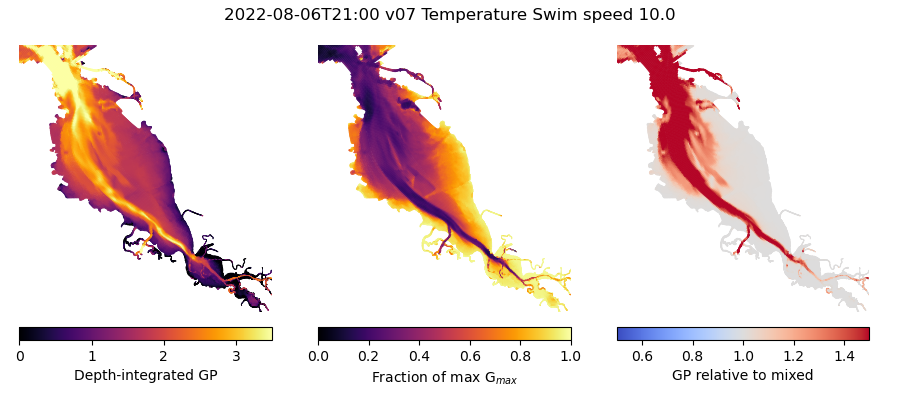

In [41]:
gs = GrowthPotentialMap(map_ds=results[0],conc_fld='conc1')
df = gs.growth_potential(tidx=105) # 2022-08-06T21:00

fig,axs = plt.subplots(1,3, figsize=(9,4.0))
for ax in axs:
    ax.axis('off')
    ax.set_adjustable('datalim')

def plot_cells(ax,v,label,**kw):
    coll = gs.map_ds.grid.plot_cells(values=v,ax=ax,**kw)
    coll.set_lw(0.5)
    coll.set_edgecolor('face')
    plt.colorbar(coll, orientation='horizontal',ax=ax, label=label, pad=0.05, fraction=0.1)
    
# Growth potential
plot_cells(axs[0],df['growth_int'],'Depth-integrated GP', cmap='inferno', clim=[0,3.5])
plot_cells(axs[1],df['growth_avg'],'Fraction of max G$_{max}$', cmap='inferno', clim=[0,1])

# Relative to no swimming
plot_cells(axs[2], df['growth_avg'] / df['growth_mixed'], cmap='coolwarm', clim=[0.5,1.5],
           label='GP relative to mixed')

t_str = str(df.attrs['time'])[:16]
fig.suptitle(f"{t_str} {df.attrs['source_dataset']} Swim speed {df.attrs['swim_speed']}")
fig.tight_layout()
for ax in axs:
    ax.axis((548258., 592431., 4146961., 4181391.))

In [42]:
# Calculate GP across all runs, tracers
calc_hourly=True
calc_daily =True

def clear_nc(nc_filename):
    # Force xarray to reread later on.
    if os.path.exists(nc_filename): 
        tmp = xr.open_dataset(nc_filename)
        tmp.close()
        del tmp
    while os.path.exists(nc_filename):
        print(f"Removing {nc_filename}")
        os.unlink(nc_filename)
        time.sleep(1.0)
    
for result in results:
    run_dir=result['run_dir'].item()
    print(f"Processing results from {run_dir}")

    for conc_fld in ['conc0','conc1']:
        hourly_fn=os.path.join(run_dir,f"growth_potential_v00_{conc_fld}.nc")
        daily_fn=os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")

        if calc_hourly: clear_nc(hourly_fn)
        if calc_daily: clear_nc(daily_fn)
            
        if calc_hourly:
            print(f"Processing concentration field {conc_fld}")
            gs = GrowthPotentialMap(map_ds=result,conc_fld=conc_fld)
            ds_results = gs.transcribe()
            if os.path.exists(hourly_fn):
                xr.open_dataset(hourly_fn).close() # maybe helps with NFS overwrite
            ds_results.to_netcdf(hourly_fn)
        else:
            print(f"Reading hourly results from {conc_fld}")
            ds_results = xr.open_dataset(hourly_fn)

        if calc_daily:
            # 24-h average
            # Model time is UTC. I want to groupby 24h, but in PDT (-7). So origin should be np.datetime64("2022-08-01 07:00")
            ds_daily = ds_results.resample({'time':'24H'}, origin=np.datetime64("2022-08-01 07:00")).mean()
            # that adds a time dimensions to grid variables, which now needs to be dropped
            for v in ['mesh','node_x','node_y','face_node','edge_node','NetNode_z']:
                if v in ds_daily and 'time' in ds_daily[v].dims:
                    ds_daily[v] = ds_daily[v].isel(time=0)
            ds_daily.to_netcdf(daily_fn)
        else:
            print(f"Skipping daily ({daily_fn})")

Processing results from bloom_tracers_v07/run_20220802T1200_20220830T0000_v00
Removing bloom_tracers_v07/run_20220802T1200_20220830T0000_v00/growth_potential_v00_conc0.nc
Removing bloom_tracers_v07/run_20220802T1200_20220830T0000_v00/growth_potential_daily_v00_conc0.nc
Processing concentration field conc0


INFO:utils:7/661
INFO:utils:13/661
INFO:utils:19/661
INFO:utils:25/661
INFO:utils:31/661
INFO:utils:36/661
INFO:utils:42/661
INFO:utils:48/661
INFO:utils:53/661
INFO:utils:58/661
INFO:utils:64/661
INFO:utils:70/661
INFO:utils:77/661
INFO:utils:83/661
INFO:utils:90/661
INFO:utils:98/661
INFO:utils:105/661
INFO:utils:113/661
INFO:utils:120/661
INFO:utils:128/661
INFO:utils:135/661
INFO:utils:142/661
INFO:utils:150/661
INFO:utils:157/661
INFO:utils:164/661
INFO:utils:172/661
INFO:utils:180/661
INFO:utils:188/661
INFO:utils:196/661
INFO:utils:204/661
INFO:utils:210/661
INFO:utils:217/661
INFO:utils:224/661
INFO:utils:231/661
INFO:utils:238/661
INFO:utils:244/661
INFO:utils:251/661
INFO:utils:258/661
INFO:utils:265/661
INFO:utils:273/661
INFO:utils:280/661
INFO:utils:287/661
INFO:utils:294/661
INFO:utils:300/661
INFO:utils:307/661
INFO:utils:314/661
INFO:utils:322/661
INFO:utils:329/661
INFO:utils:336/661
INFO:utils:343/661
INFO:utils:349/661
INFO:utils:356/661
INFO:utils:363/661
INFO:utils

Removing bloom_tracers_v07/run_20220802T1200_20220830T0000_v00/growth_potential_v00_conc1.nc
Removing bloom_tracers_v07/run_20220802T1200_20220830T0000_v00/growth_potential_daily_v00_conc1.nc
Processing concentration field conc1


INFO:utils:34/661
INFO:utils:68/661
INFO:utils:100/661
INFO:utils:135/661
INFO:utils:170/661
INFO:utils:205/661
INFO:utils:240/661
INFO:utils:275/661
INFO:utils:310/661
INFO:utils:343/661
INFO:utils:377/661
INFO:utils:412/661
INFO:utils:446/661
INFO:utils:479/661
INFO:utils:513/661
INFO:utils:547/661
INFO:utils:582/661
INFO:utils:616/661
INFO:utils:649/661


Processing results from bloom_tracers_v08/run_20220802T1930_20220830T0000_v00
Processing concentration field conc0


INFO:utils:9/654
INFO:utils:17/654
INFO:utils:26/654
INFO:utils:33/654
INFO:utils:44/654
INFO:utils:59/654
INFO:utils:73/654
INFO:utils:88/654
INFO:utils:102/654
INFO:utils:117/654
INFO:utils:132/654
INFO:utils:147/654
INFO:utils:162/654
INFO:utils:177/654
INFO:utils:191/654
INFO:utils:205/654
INFO:utils:218/654
INFO:utils:234/654
INFO:utils:253/654
INFO:utils:271/654
INFO:utils:332/654
INFO:utils:392/654
INFO:utils:453/654
INFO:utils:510/654
INFO:utils:571/654
INFO:utils:631/654


Processing concentration field conc1


INFO:utils:37/654
INFO:utils:65/654
INFO:utils:114/654
INFO:utils:163/654
INFO:utils:212/654
INFO:utils:257/654
INFO:utils:283/654
INFO:utils:299/654
INFO:utils:314/654
INFO:utils:367/654
INFO:utils:427/654
INFO:utils:483/654
INFO:utils:543/654
INFO:utils:603/654


In [43]:
from matplotlib import cm
import stompy.plot.cmap as scmap

def skew_divergent(cmap,clim,center=1.0):
    alpha=(1.0-clim[0])/(clim[1]-clim[0])
    beta = np.log(0.5) / np.log(alpha)

    return scmap.cmap_transform(cmap,lambda x: x**beta)

/tmp/ipykernel_12237/4185688017.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig,axs = plt.subplots(1,3, figsize=(9,4.0))
INFO:utils:8/28
INFO:utils:16/28
INFO:utils:24/28
INFO:utils:8/28
INFO:utils:16/28
INFO:utils:23/28


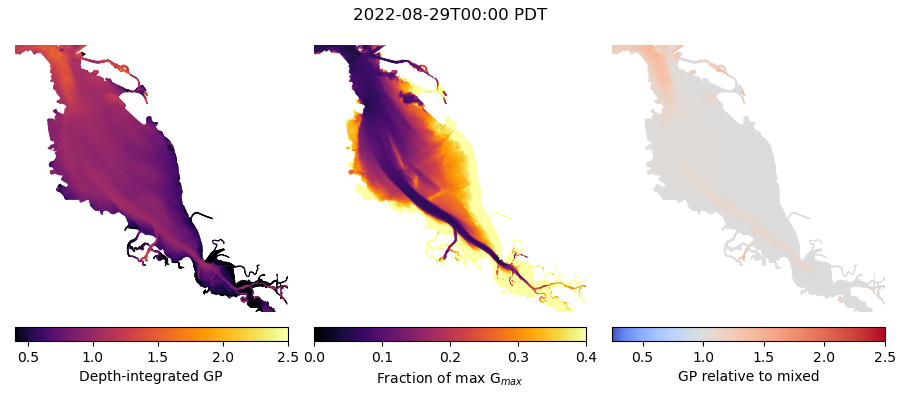

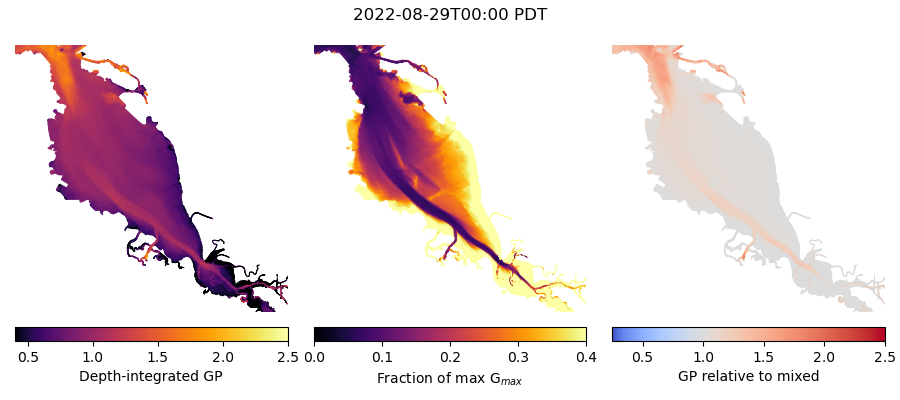

In [49]:
# Render the daily maps
def render_daily_maps(result, conc_fld):
    run_dir = result['run_dir'].item()
    daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
    ds_daily=xr.open_dataset(daily_fn)

    fig_dir=os.path.join(run_dir,'growth_potential_daily_v00_figs')
    if not os.path.exists(fig_dir):
        os.makedirs(fig_dir)
    
    fig,axs = plt.subplots(1,3, figsize=(9,4.0))
    for ax in axs:
        ax.axis('off')
        ax.set_adjustable('datalim')

    def plot_cells(ax,values,label,**kw):
        if callable(values): values=values()
        coll = ds.grid.plot_cells(values=values,ax=ax,**kw)
        coll.set_lw(0.5)
        coll.set_edgecolor('face')
        plt.colorbar(coll, orientation='horizontal',ax=ax, label=label, pad=0.05, fraction=0.1)

    snap=ds_daily.isel(time=0)

    panels=[dict(ax=axs[0], values=lambda: snap['growth_int'], label='Depth-integrated GP', 
                 cmap=scmap.cmap_transform(cm.inferno,lambda x: x**0.7), clim=[0.4,2.5]),
            dict(ax=axs[1],values=lambda: snap['growth_avg'],label='Fraction of max G$_{max}$', cmap='inferno', clim=[0,0.4]),
            dict(ax=axs[2],values=lambda: snap['growth_avg'] / snap['growth_mixed'], 
                 cmap=skew_divergent(cm.coolwarm,[0.25,2.5]), clim=[0.25,2.5],
                 label='GP relative to mixed')
           ]

    for panel in panels:
        plot_cells(**panel)
    
    def time_str(): return str(snap['time'].values - np.timedelta64(7,'h'))[:16] + " PDT"

    fig.suptitle(time_str())
    fig.tight_layout()
    for ax in axs:
        ax.axis((548258., 592431., 4146961., 4181391.))

    for tidx in utils.progress(range(ds_daily.dims['time'])):
        snap=ds_daily.isel(time=tidx)
        for panel in panels:
            values = panel['values']
            if callable(values): values=values()
            panel['ax'].collections[0].set_array(values)
        fig.suptitle(time_str())
        plt.draw()
        fig.savefig(os.path.join(fig_dir,f"growth_potential_{conc_fld}_{tidx:04d}.png"),dpi=200)

#render_daily_maps(results[0],'conc0')
#render_daily_maps(results[0],'conc1')
render_daily_maps(results[1],'conc0')
render_daily_maps(results[1],'conc1')

In [44]:
# Timeseries at several points
pnts_distributed=[
    (None, [559600,4.1795e6]), # just south of Alameda 
    (None, [556100,4.1820e6]), # epicenter 
    (None, [562200,4.1637e6]), # east of SFO
    (None, [569400,4.1670e6]), # Hayward-ish
]


def ax_grid_bathy(ax,grid):
    ax.set_adjustable('datalim')
    ax.axis('off')
    grid.contourf_node_values(grid.nodes['NetNode_z'],np.linspace(-20,10,64), cmap='terrain',
                              extend='both',ax=ax) 
    ax.axis('equal')
    ax.axis((548258., 592431., 4146961., 4181391.))
    
def fig_gp_timeseries_one(ds):
    gs=gridspec.GridSpec( 3,2, width_ratios=[0.33,0.67])
    
    grid = unstructured_grid.UnstructuredGrid.read_ugrid(ds)
    
    fig=plt.figure(figsize=(9,6))

    ax_grid=fig.add_subplot(gs[:2,0])
    ax_grid_bathy(ax_grid,grid)
    
    markers = [ ax_grid.plot(pnt[0],pnt[1],marker='o',lw=0, mew=1, mec='k') for pnt in pnts]
    colors=[m[0].get_color() for m in markers]
    
    cells=[grid.select_cells_nearest(p) for p in pnts]
    
    ax0=fig.add_subplot(gs[0,1])
    ax1=fig.add_subplot(gs[1,1],sharex=ax0)
    ax2=fig.add_subplot(gs[2,1],sharex=ax0)
    
    for cell,color in zip(cells, colors):
        ax0.plot(ds.time, ds['growth_int'].isel(cell=cell))
        ax1.plot(ds.time, ds['growth_avg'].isel(cell=cell))
        ax2.plot(ds.time, ds['growth_avg'].isel(cell=cell) / ds['growth_mixed'].isel(cell=cell))
    ax0.set_ylabel('Depth-integrated')
    ax1.set_ylabel('Depth-averaged')
    ax2.set_ylabel('Relative to mixed')
    for ax in [ax0,ax1]:
        plt.setp(ax.get_xticklabels(),visible=0)
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98, top=0.93,bottom=0.12)
    title = f"{ds.attrs['source_dataset']}  Swimming {ds.attrs['swim_speed']} m/d"
    fig.suptitle(title)
    return fig


def fig_gp_timeseries_multi(dss,lss=['-','--',':'],pnts = pnts_distributed):
    gs=gridspec.GridSpec( 3,2, width_ratios=[0.33,0.67])
    
    grid = unstructured_grid.UnstructuredGrid.read_ugrid(dss[0])
    
    fig=plt.figure(figsize=(9,6))

    ax_grid=fig.add_subplot(gs[:2,0])
    ax_grid_bathy(ax_grid,grid)
    
    markers = [ ax_grid.plot(pnt[0],pnt[1],color=col,marker='o',lw=0, mew=1, mec='k') for col,pnt in pnts]
    colors=[m[0].get_color() for m in markers]
    ax0=fig.add_subplot(gs[0,1])
    ax1=fig.add_subplot(gs[1,1],sharex=ax0)
    ax2=fig.add_subplot(gs[2,1],sharex=ax0)
    
    cells=[grid.select_cells_nearest(p) for col,p in pnts]

    for ds,ls in zip(dss,lss):
        ds_label = f"{ds.attrs['source_dataset']}, {ds.attrs['swim_speed']} m/d"
        for cell,color in zip(cells, colors):
            style=dict(color=color,ls=ls)
            if cell==cells[0]:
                style['label']=ds_label
            else:
                style['label']=None
            ax0.plot(ds.time, ds['growth_int'].isel(cell=cell),**style)
            ax1.plot(ds.time, ds['growth_avg'].isel(cell=cell),**style)
            ax2.plot(ds.time, ds['growth_avg'].isel(cell=cell) / ds['growth_mixed'].isel(cell=cell),**style)
    ax0.set_ylabel('Depth-integrated')
    ax1.set_ylabel('Depth-averaged')
    ax2.set_ylabel('Relative to mixed')
    for ax in [ax0,ax1]:
        plt.setp(ax.get_xticklabels(),visible=0)
    fig.autofmt_xdate()
    fig.subplots_adjust(right=0.98, top=0.93,bottom=0.12)
    ax2.legend(loc='upper right',bbox_to_anchor=(-0.1,1.0),frameon=False)
    return fig

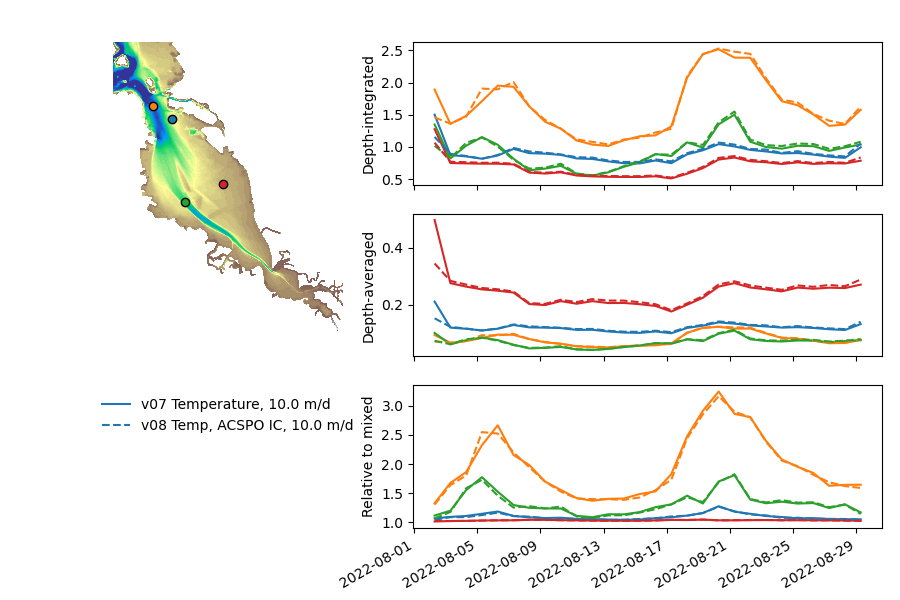

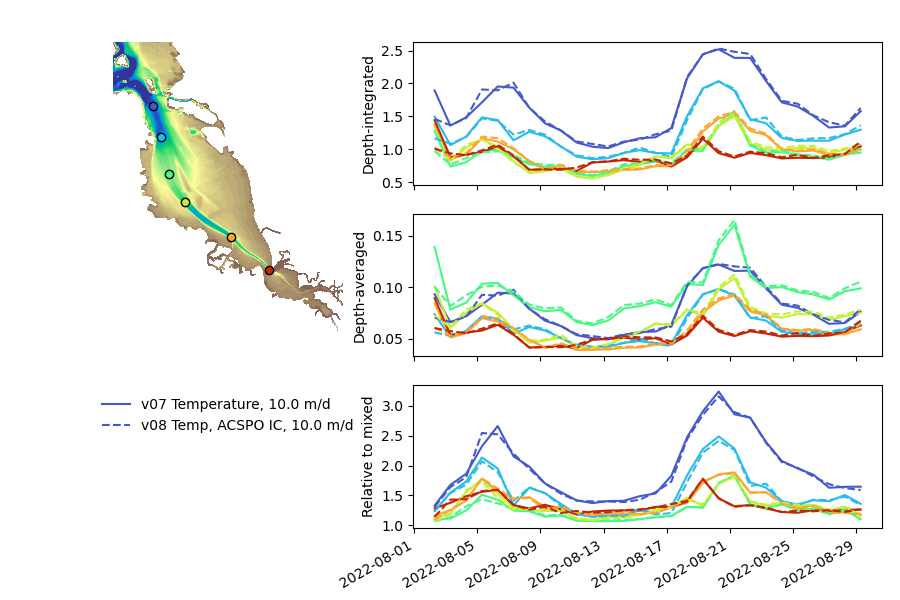

In [45]:
# Temp vs no-temp, swim=10 m/d
dss=[]
for result in results:
    run_dir = result['run_dir'].item()
    conc_fld = 'conc1'
    daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
    dss.append(xr.open_dataset(daily_fn))

fig_gp_timeseries_multi(dss, pnts=pnts_distributed) ;

from matplotlib import cm
cmap=cm.turbo
pnts_thalweg=[
    (cmap(0.1), [556100,4.1820e6]), # epicenter 
    (cmap(0.25), [557500,4.1761e6]), # Hunters Point
    (cmap(0.4), [559000,4.1690e6]), # San Bruno Shoal
    (cmap(0.55), [562200,4.1637e6]), # east of SFO
    (cmap(0.7), [571000,4.15700e6]), # Redwood Ck
    (cmap(0.9), [578290,4.15072e6]), # Dumbarton
]
fig_gp_timeseries_multi(dss, pnts=pnts_thalweg) ;

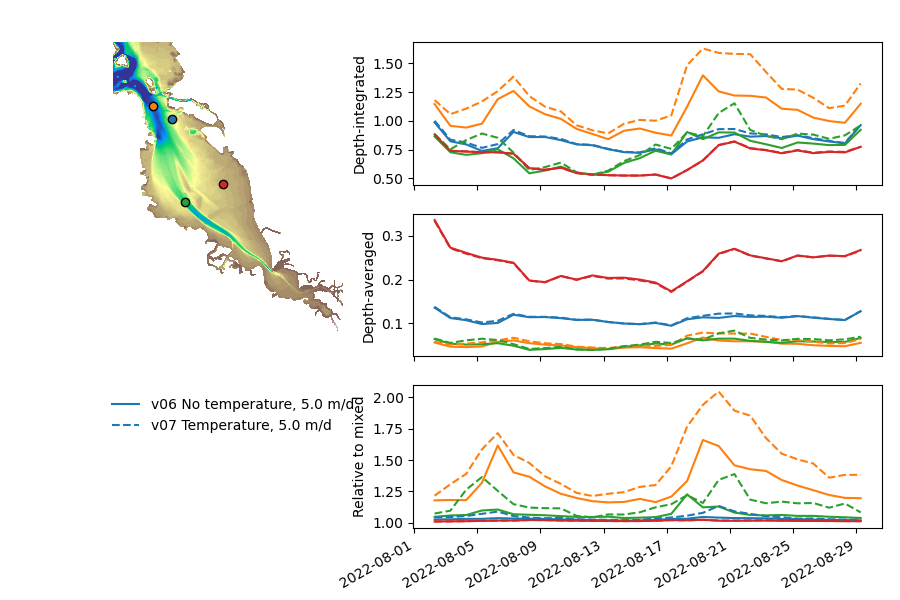

In [19]:
# Temp vs no-temp, swim=5 m/d
dss=[]
for result in results:
    run_dir = result['run_dir'].item()
    conc_fld = 'conc0'
    daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
    dss.append(xr.open_dataset(daily_fn))

fig_gp_timeseries_multi(dss) ;

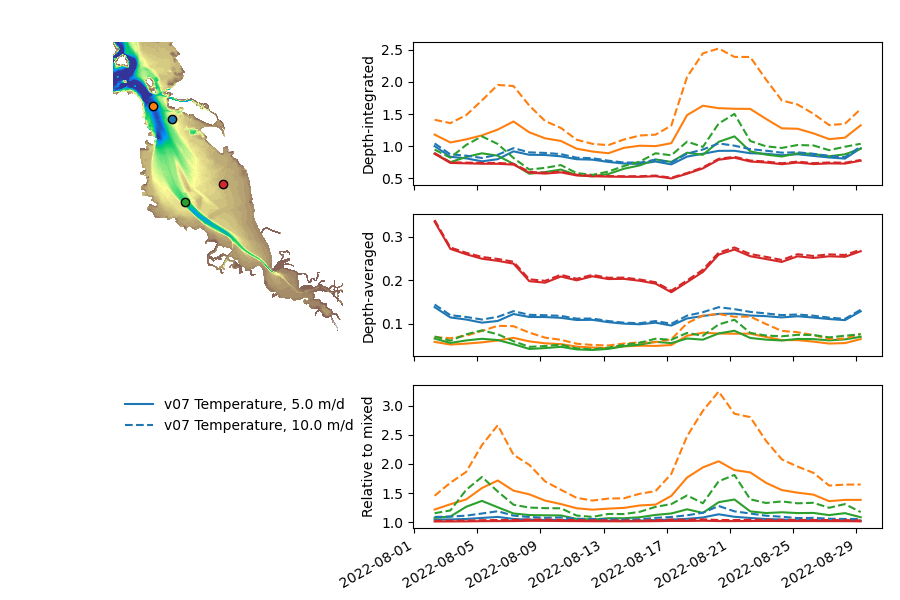

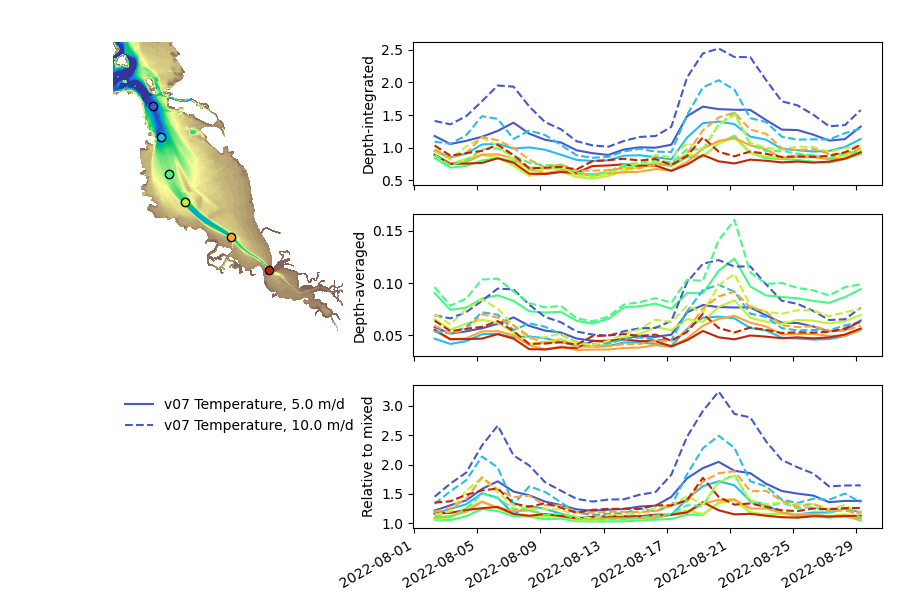

In [29]:
# Temp, 5 m/d vs 10 m/d
dss=[]
result = results[1]
run_dir = result['run_dir'].item()
for conc_fld in ['conc0','conc1']:
    daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
    dss.append(xr.open_dataset(daily_fn))

fig_gp_timeseries_multi(dss) ;
fig_gp_timeseries_multi(dss, pnts=pnts_thalweg) ;

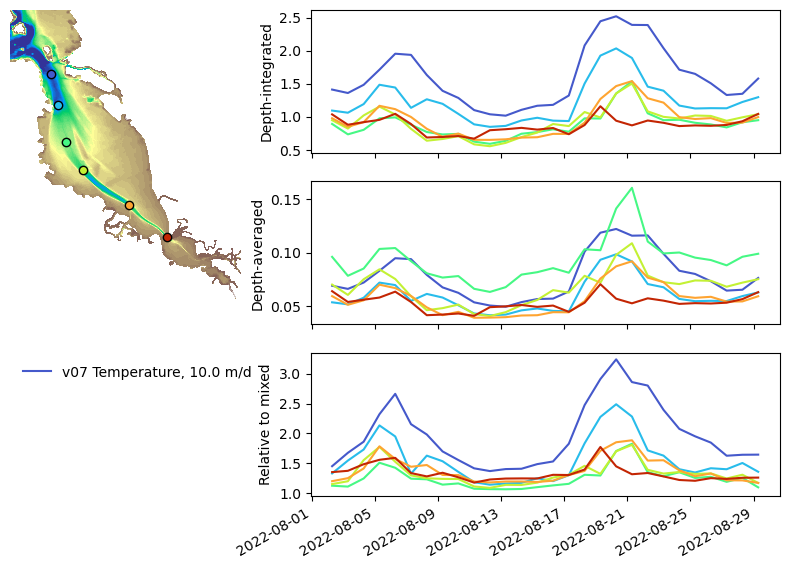

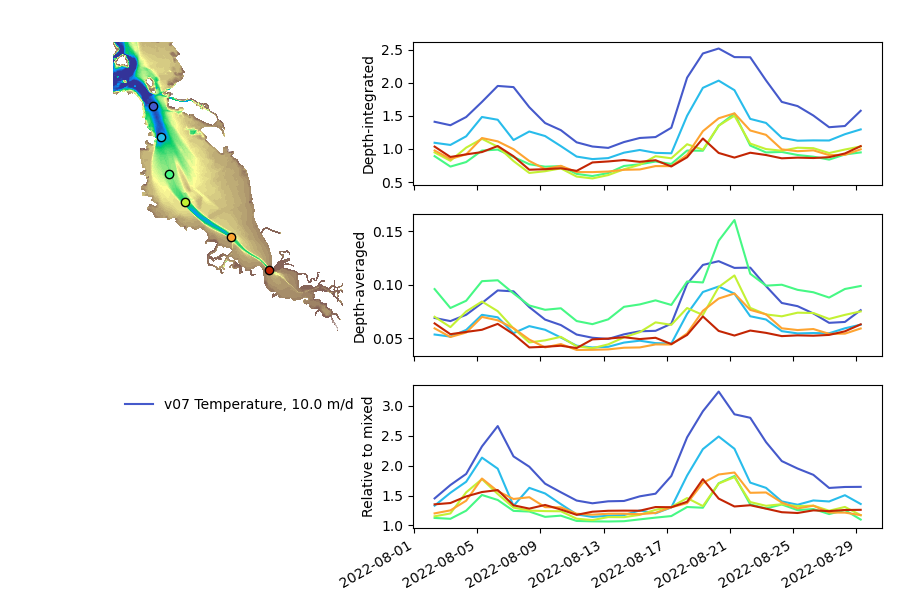

In [30]:
fig_gp_timeseries_multi(dss[1:], pnts=pnts_thalweg)

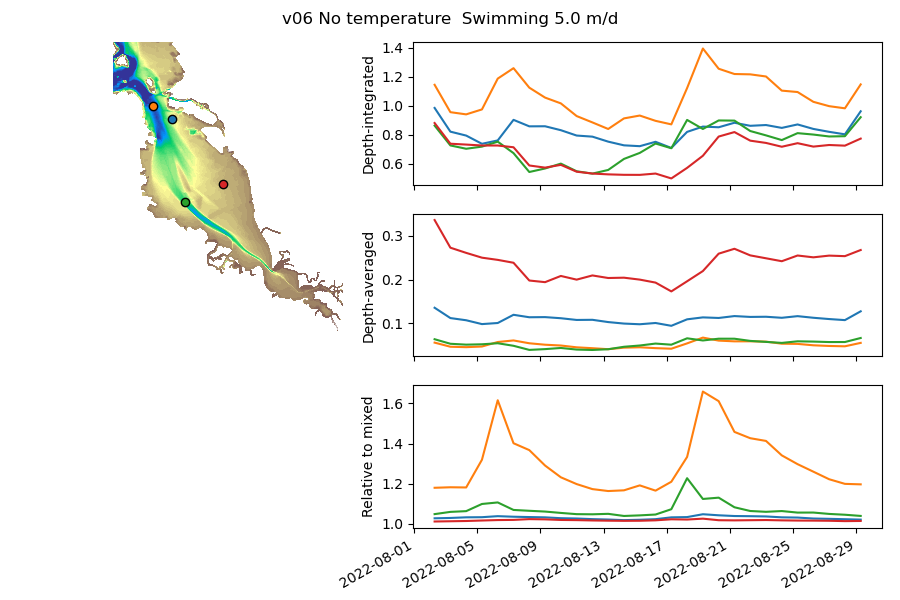

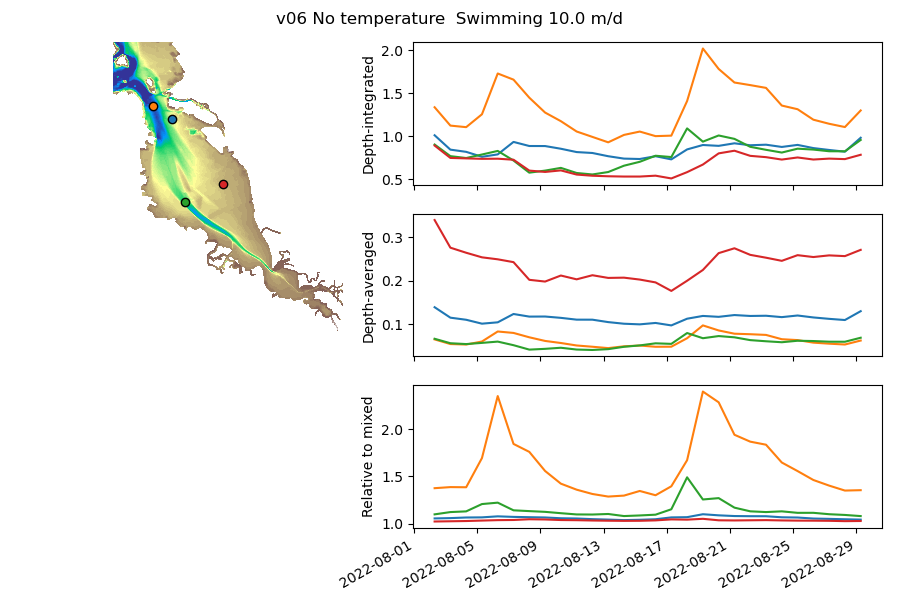

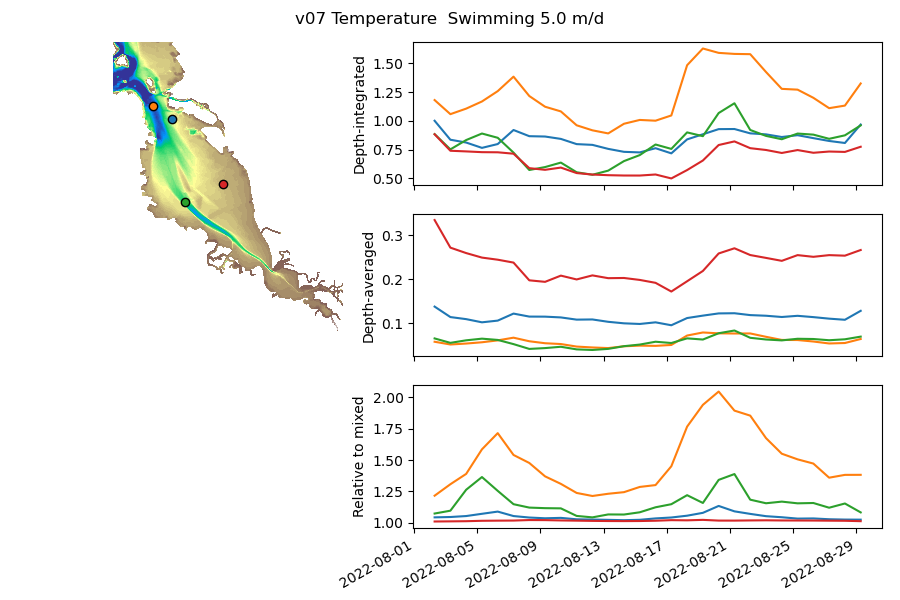

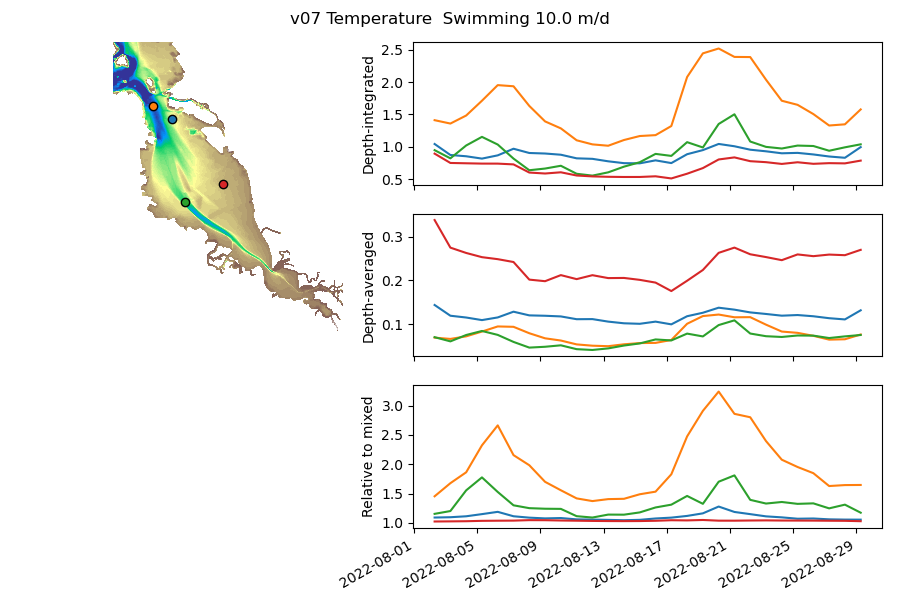

In [21]:
for result in results:
    run_dir = result['run_dir'].item()
    for conc_fld in ['conc0','conc1']:
        daily_fn = os.path.join(run_dir,f"growth_potential_daily_v00_{conc_fld}.nc")
        ds_daily = xr.open_dataset(daily_fn)
        fig = fig_gp_timeseries_one(ds_daily)
